## Import Packages

In [15]:
import numpy as np 
seed= 42
np.random.seed( seed )


import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

# utility
import os
import sys
from pprint import pprint
from IPython.display import display
import gc
from tqdm import tqdm
from collections import Counter
import typing
import pickle

# visualizations
import matplotlib.pyplot as plt

# NLP
import gensim

# modelling and data
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.utils import class_weight

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

## NN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, TimeDistributed
from tensorflow.keras.layers import Input, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


# multiprocessing
from multiprocessing import Pool

## Build a better model than baseline

Try

1. an stacked LSTM model

2. bidirectional LSTM 

3. CNN model

4. stacking of all machines

### data preparation for the LSTM model:

Because LSTM model is a sequence learning model, we cannot featurize our data as we did for the baseline models. We need to model our input data as a sequence problem.

Here for every document, we have a sequence of letters. These letters need to be integer encoded before we use them. After integer encoding them, they are passed through an embedding layer.

For LSTMs, the shape of input must be in the form of **[samples, timesteps, features]**

### stacked LSTM

In [16]:
def create_tokenizer(corpus: typing.List[str]
                     ) -> Tokenizer:
    
    """
    - It takes the corpus to train a tokenizer on. 
        Usually we fit the tokenizer on the train data
    - It returns the tokenizer object
    """
    # if there will be an oov token, it will be assigned 0
    # we can also determine oov_token by setting oov_token= max_length+1
    tokenizer = Tokenizer(char_level=True) 
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def encode_text(tokenizer: Tokenizer, 
                corpus: typing.List[ typing.List[str]],
                max_len: int) -> np.array:
    # character tokenize the documents
    encoded= tokenizer.texts_to_sequences(corpus)
    padded= sequence.pad_sequences(encoded, maxlen= max_len)
    return padded

In [17]:
def stacked_LSTM(timesteps: int, 
                 output_size: int,
                 vocab_size: int) -> Sequential:
    """
    - timesteps: The length of the sequence
    - output_size: It's a multiclass classification problem
    - vocab_size: Total number of words (or letters in our case)
    
    It returns a sequential model
    """
    kernel= 'normal'
    embedding_size= 4
        
    model= Sequential(name= 'sequential')
    model.add(Embedding(input_dim= vocab_size,
                        output_dim= embedding_size,
                        input_length= timesteps,
                        name= 'embedding'))
    #model.add( SpatialDropout1D(0.3) )
    model.add( LSTM(200, return_sequences= True, name='LSTM_1'))
    model.add( LSTM(200, name='LSTM_2'))
    #model.add( LSTM(200, name='LSTM_3'))
    model.add( Dense(500, activation= 'relu', kernel_initializer= kernel, name= 'dense_1'))
    model.add(Dropout(0.5))
    model.add( Dense(250, activation= 'relu', kernel_initializer= kernel, name= 'dense_2'))
    model.add(Dropout(0.5))
    model.add( Dense(100, activation= 'relu', kernel_initializer= kernel, name= 'dense_3'))
    model.add(Dropout(0.5))
    model.add( Dense(y_train.shape[1], activation= 'softmax', kernel_initializer= kernel, name= 'dense_4'))
    
    model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    plot_model(model, show_shapes= True, to_file= 'stacked_LSTM.png')
    model.summary()
    
    return model

### Bidirectional LSTM

In [18]:
def bidirectional_LSTM(timesteps: int, 
                       output_size: int,
                       vocab_size: int) -> Sequential:
    kernel= 'normal'
    embedding_size= 4

    model= Sequential(name='sequential')
    model.add(Embedding(input_dim= vocab_size,
                        output_dim= embedding_size,
                        input_length= timesteps,
                        name= 'embedding'))
    model.add( Bidirectional(LSTM(200, 
                                  dropout=0.3, 
                                  recurrent_dropout=0.3,
                                  name= 'LSTM_1'),
                            name= 'bidirectional') )
    model.add( Dense(500, activation= 'relu', kernel_initializer= kernel, name= 'dense_1'))
    model.add(Dropout(0.5))
    model.add( Dense(250, activation= 'relu', kernel_initializer= kernel, name= 'dense_2'))
    model.add(Dropout(0.5))
    model.add( Dense(100, activation= 'relu', kernel_initializer= kernel, name= 'dense_3'))
    model.add(Dropout(0.5))
    model.add( Dense(y_train.shape[1], activation= 'softmax', kernel_initializer= kernel, name= 'dense_4'))
    
    model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    plot_model(model, show_shapes= True, to_file= 'bidirectional_LSTM.png')
    model.summary()
    return model

### CNN model

In [19]:
def CNN_model(timesteps: int, 
              vocab_size: int) -> Model:
    """
    We use a multi-channel CNN model to do the text classification wherein each chanel, we use 
    a certain filter size
    """
    embedding_size= 4
    
    # the multichannel part
    inputs= list()
    flats= list()
    
    for i, ks in enumerate([4, 6, 8, 10, 12]):
        input_= Input(shape= (timesteps, 1), name= f'input_{i}')
        embedding= Embedding(vocab_size, embedding_size, name= f'embedding_{i}') (input_)
        
        conv_one= Conv2D(filters= 256, kernel_size= (ks, embedding_size),
                         padding= 'same', activation= 'relu', name= f'conv_one_{i}')(embedding)
        drop_one= Dropout(0.5, name= f'dropout_one_{i}')(conv_one)
        pool_one= MaxPooling2D( pool_size= (timesteps-ks+1, 1), name= f'pooling_one_{i}')(drop_one)
        
        #conv_two= Conv2D(filters= 128, kernel_size= (ks, embedding_size), 
        #                 padding= 'same', activation= 'relu', name= f'conv_two_{i}')(pool_one)
        #drop_two= Dropout(0.5, name= f'dropout_two_{i}')(conv_two)
        
        flat= Flatten(name= f'flatten_{i}')(pool_one)
        
        inputs.append(input_)
        flats.append(flat)
        
    merged= concatenate(flats, name= 'merged')
    # The dense layers part
    dense1= Dense(512, activation= 'relu', name= 'dense_1')(merged)
    drop1= Dropout(0.5, name= 'dropout_1')(dense1)
    dense2= Dense(256, activation= 'relu', name= 'dense_2')(drop1)
    drop2= Dropout(0.5, name= 'dropout_2')(dense2)
    dense3= Dense(y_train.shape[1], activation= 'softmax', name= 'dense_3') (drop2)
    
    # build the model
    model= Model(inputs= inputs, outputs= dense3)
    
    # compile
    model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    
    #model.sumamry()
    plot_model(model, show_shapes= True, to_file= 'multichannel_cnn.png')
    return model

    

### Data Preparation

In [20]:
path= os.path.join('/kaggle', 'input', 'obfuscated_text', 'xtrain_obfuscated.txt')
xtrain= pd.read_csv(path, header= None)
xtrain.columns= ['text']

path= os.path.join('/kaggle', 'input', 'obfuscated_text', 'xtest_obfuscated.txt')
xtest= pd.read_csv(path, header= None)
xtest.columns= ['text']

path= os.path.join('/kaggle', 'input', 'obfuscated_text', 'ytrain.txt')
ytrain= pd.read_csv(path, header= None)
ytrain.columns= ['label']

data= pd.concat([xtrain, ytrain], axis= 1)
data= pd.concat([data, xtest], axis= 0)
data['length']= data['text'].apply(len)

#####################################   data    #####################################
tokenizer= create_tokenizer(corpus= xtrain['text'].tolist())
X_train= encode_text(tokenizer,
                 corpus= [list(el) for el in xtrain['text'].tolist()],
                 max_len= data['length'].max())
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test= encode_text(tokenizer,
                 corpus= [list(el) for el in xtest['text'].tolist()],
                 max_len= data['length'].max())

y_train= utils.to_categorical(ytrain)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (32513, 452, 1)
y_train shape:  (32513, 12)
X_test shape:  (3000, 452)


### Create validation data from X_train, y_train

In [21]:
X_tr, X_val, y_tr, y_val= train_test_split(X_train, 
                                           y_train, 
                                           test_size= 0.2,
                                           random_state= seed,
                                           stratify= ytrain.values)
print('X_tr shape: ', X_tr.shape)
print('y_tr shape: ', y_tr.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)

X_tr shape:  (26010, 452, 1)
y_tr shape:  (26010, 12)
X_val shape:  (6503, 452, 1)
y_val shape:  (6503, 12)


### TPU initialization

In [22]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)



### Saving models

In [23]:
def save_dl_model(model: typing.Any, 
                  model_path: str,
                  model_weights_path: str) -> None:
    """
    It saves a deep learning model to given pathes. 
    model can either be sequential or keras Model class
    """
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights( model_weights_path )
    print("Saved model to disk")

In [24]:
def write_pickle(var: typing.Any, 
                 path: str) -> None:
    """
    Writes variable var to path.
    """
    with open(path, 'wb') as f:
        pickle.dump(var, f, protocol = pickle.HIGHEST_PROTOCOL)

In [25]:
#classes= np.unique(ytrain['label'])
#class_weights= list( class_weight.compute_class_weight('balanced', 
#                                                        classes,
#                                                        ytrain['label'].values) )
#class_weights= {k: class_weights[i] for i, k in enumerate(classes)}

### training models

In [26]:
train_stacked_LSTM = True
train_bidirectional_LSTM = False
train_multichannel_CNN = True

Epoch 1/70
407/407 [==============================] - 17s 42ms/step - accuracy: 0.2048 - loss: 2.2228 - val_accuracy: 0.2931 - val_loss: 2.0234
Epoch 2/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.4241 - loss: 1.6718 - val_accuracy: 0.5319 - val_loss: 1.3490
Epoch 3/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.5597 - loss: 1.2641 - val_accuracy: 0.6023 - val_loss: 1.1650
Epoch 4/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.6146 - loss: 1.1132 - val_accuracy: 0.6598 - val_loss: 1.0081
Epoch 5/70
407/407 [==============================] - 10s 24ms/step - accuracy: 0.6474 - loss: 1.0271 - val_accuracy: 0.7092 - val_loss: 0.9059
Epoch 6/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.6756 - loss: 0.9553 - val_accuracy: 0.7392 - val_loss: 0.8318
Epoch 7/70
407/407 [==============================] - 9s 22ms/step - accuracy: 0.7068 - loss: 0.8803 - val_accuracy: 0.7403 - val_loss: 0.80

Epoch 58/70
407/407 [==============================] - 10s 24ms/step - accuracy: 0.8497 - loss: 0.4434 - val_accuracy: 0.8335 - val_loss: 0.4956
Epoch 59/70
407/407 [==============================] - 10s 25ms/step - accuracy: 0.8467 - loss: 0.4464 - val_accuracy: 0.8445 - val_loss: 0.4744
Epoch 60/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.8500 - loss: 0.4424 - val_accuracy: 0.8385 - val_loss: 0.4838
Epoch 61/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.8482 - loss: 0.4398 - val_accuracy: 0.8335 - val_loss: 0.4893
Epoch 62/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.8492 - loss: 0.4423 - val_accuracy: 0.8495 - val_loss: 0.4723
Epoch 63/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.8531 - loss: 0.4344 - val_accuracy: 0.8356 - val_loss: 0.4898
Epoch 64/70
407/407 [==============================] - 9s 23ms/step - accuracy: 0.8504 - loss: 0.4384 - val_accuracy: 0.8427 - val_los

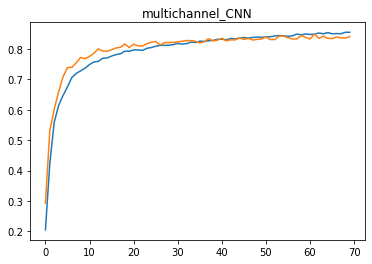

Saved model to disk


In [28]:
with tpu_strategy.scope():
    
    if train_stacked_LSTM:
        # training stacked LSTM
        model= stacked_LSTM(timesteps = X_tr.shape[1],
                            output_size = y_tr.shape[1],
                            vocab_size = len(tokenizer.word_index) + 1)
        history= model.fit(X_tr, y_tr, 
                           epochs= 300, 
                           batch_size= 128, 
                           validation_data= (X_val, y_val))
        plt.plot( history.history['accuracy'])
        plt.plot( history.history['val_accuracy'])
        plt.title('stacked_LSTM')
        plt.show()
        plt.close()
        save_dl_model(model = model,
                      model_path = os.path.join( os.getcwd(), 'stacked_LSTM.json'),
                      model_weights_path = os.path.join( os.getcwd(), 'stacked_LSTM.h5'))
        # save history
        pd.DataFrame(history.history).to_csv('stacked_LSTM_history.csv')
    ####################################################################
    if train_bidirectional_LSTM:
        # training bidirectional LSTM
        model= bidirectional_LSTM(timesteps = X_tr.shape[1],
                                  output_size = y_tr.shape[1],
                                  vocab_size = len(tokenizer.word_index) + 1)

        history= model.fit(X_tr, y_tr, 
                           epochs= 500, 
                           batch_size= 128, 
                           validation_data= (X_val, y_val))
        plt.plot( history.history['accuracy'])
        plt.plot( history.history['val_accuracy'])
        plt.title('bidirectional_LSTM')
        plt.show()
        plt.close()
        save_dl_model(model = model,
                      model_path = os.path.join( os.getcwd(), 'bidirectional_LSTM.json'),
                      model_weights_path = os.path.join( os.getcwd(), 'bidirectional_LSTM.h5'))
        # save history
        pd.DataFrame(history.history).to_csv('bidirectional_LSTM_history.csv')
    ####################################################################
    if train_multichannel_CNN:
        num_channels= 5
        model= CNN_model(timesteps = X_tr.shape[1],
                         vocab_size = len(tokenizer.word_index) + 1)
        history= model.fit( [X_tr]*num_channels, 
                            y_tr, 
                            validation_data= ([X_val]*num_channels, y_val),  
                            epochs= 100, batch_size= 64 )
        plt.plot( history.history['accuracy'])
        plt.plot( history.history['val_accuracy'])
        plt.title('multichannel_CNN')
        plt.show()
        plt.close()
        save_dl_model(model = model,
                      model_path = os.path.join( os.getcwd(), 'multichannel_CNN.json'),
                      model_weights_path = os.path.join( os.getcwd(), 'multichannel_CNN.h5'))
        # save history
        pd.DataFrame(history.history).to_csv('multichannel_CNN_history.csv')
        ####### predict X_test for CNN
        y_test_predicted = model.predict([X_test]*num_channels)
        y_test_predicted = pd.DataFrame(np.argmax(y_test_predicted, 
                                                  axis= 1 )
                                       , columns= ['y_test_predicted'])
        y_test_predicted.to_csv('y_test_predicted.csv')
